/opt/homebrew/lib/python3.11/site-packages/pvlib/pvsystem.py:2463: pvlibDeprecationWarning: 
The pvlib.pvsystem.singlediode parameter ivcurve_pnts was deprecated in pvlib 0.10.0 and will be removed in 0.11.0. Use pvlib.pvsystem.v_from_i and pvlib.pvsystem.i_from_v instead.
  warn_deprecated('0.10.0', name='pvlib.pvsystem.singlediode',


          P_load  P_PV         P_bat           SoC         P_h  P_H2G  \
0      94.807301  -0.0  0.000000e+00  0.000000e+00   94.807301    0.0   
1      94.807301  -0.0  0.000000e+00  0.000000e+00   94.807301    0.0   
2      95.304024   0.0  0.000000e+00  0.000000e+00   95.304024    0.0   
3      97.469611   0.0  0.000000e+00  0.000000e+00   97.469611    0.0   
4     100.855197   0.0  0.000000e+00  0.000000e+00  100.855197    0.0   
...          ...   ...           ...           ...         ...    ...   
5755  484.321079   0.0 -7.374379e-72  2.522814e-76  484.321079    0.0   
5756  480.148613   0.0 -7.190020e-73  2.459744e-77  480.148613    0.0   
5757  475.536500   0.0 -7.010269e-74  2.398250e-78  475.536500    0.0   
5758  470.728930   0.0 -6.835013e-75  2.338294e-79  470.728930    0.0   
5759  466.508541   0.0 -6.664137e-76  2.279836e-80  466.508541    0.0   

           P_G2H  Bat_charge  Bat_discharge  
0      94.807301         0.0   0.000000e+00  
1      94.807301         0.0   

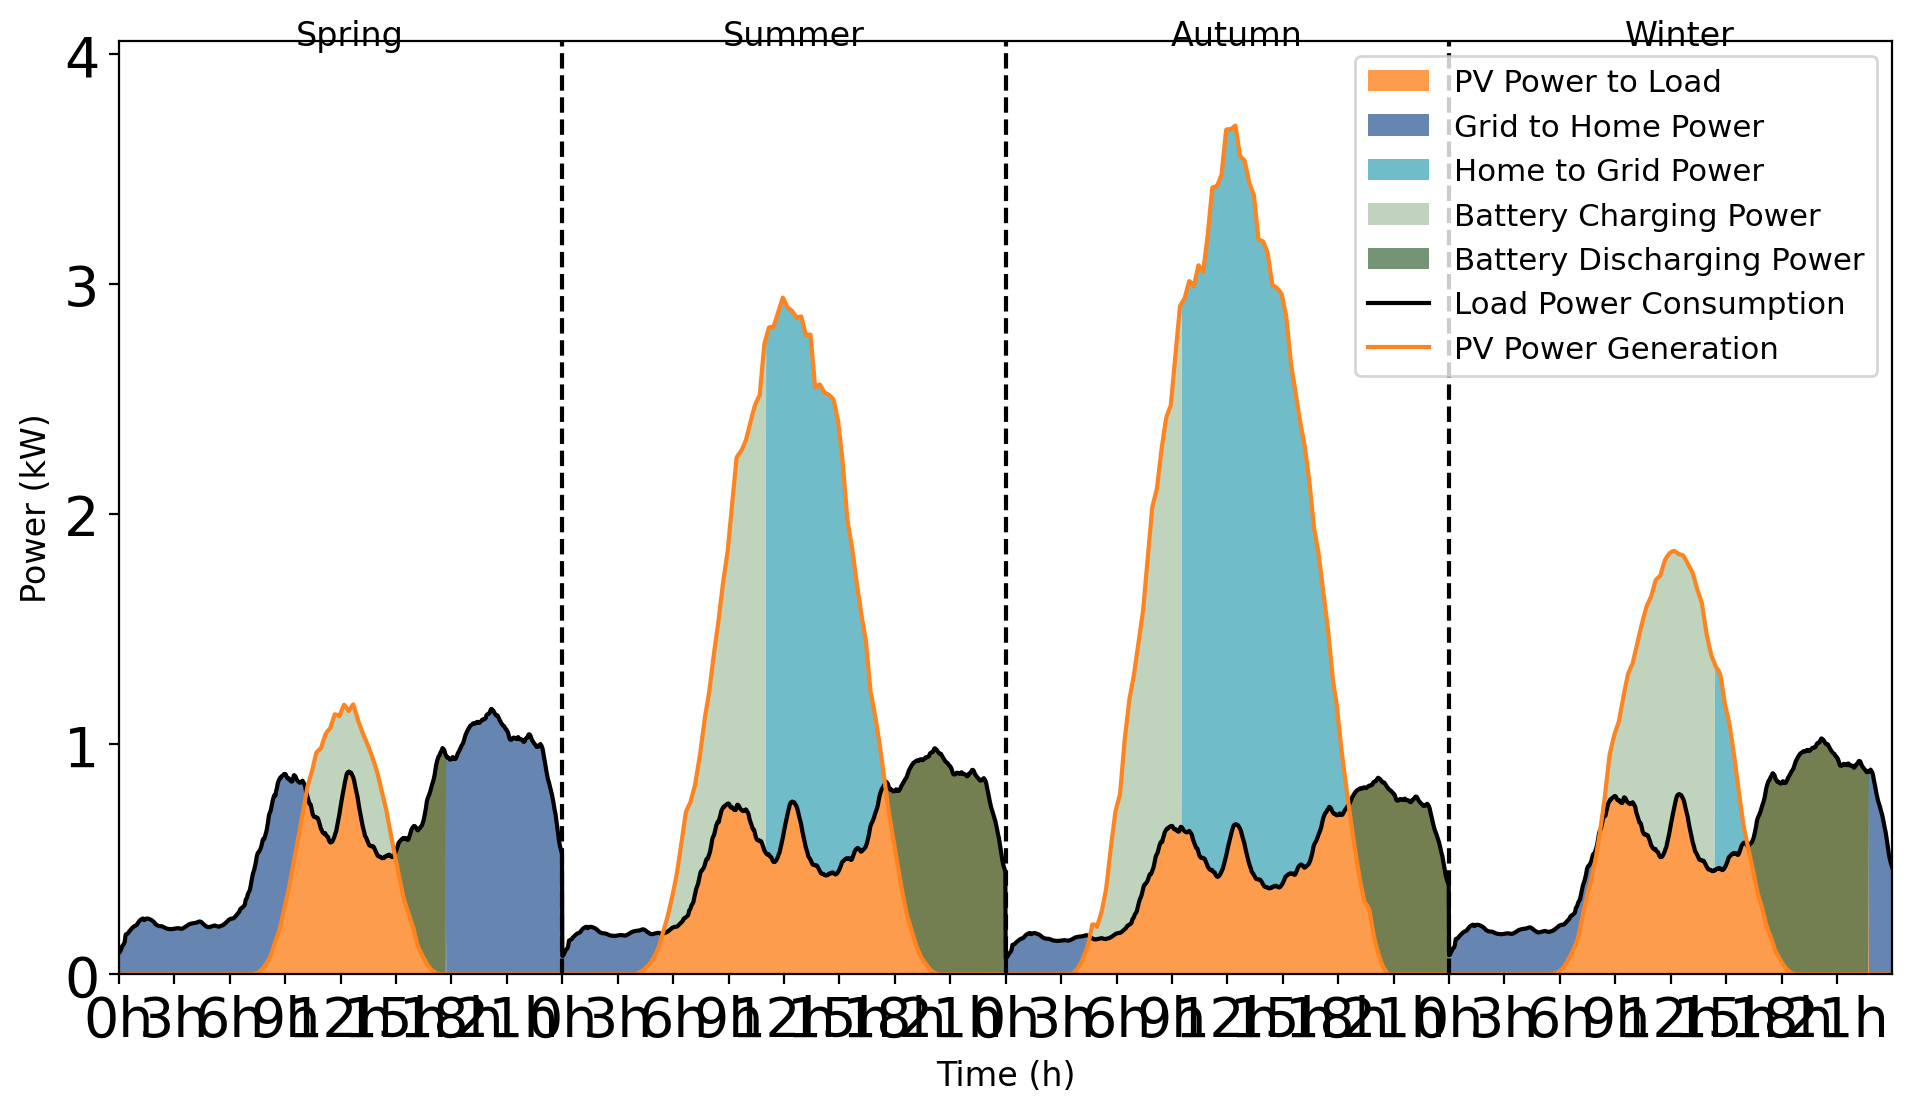

In [72]:
%config InlineBackend.figure_format = 'retina'  # This sets a higher DPI (e.g., for high-resolution displays)

from pvlib import pvsystem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from parameters_pv import parameters, LLE_parameters
import matplotlib.ticker as ticker


# Constants
C_bat = 5000  # Battery capacity in kWh, for example
n_c = 0.95  # Charging efficiency
n_d = 0.95  # Discharging efficiency
P_max_c = 2500  # Charging power max
P_max_d = 2500  # Discharging power max
delta_t = 60  # Time step in hours
SoC_max = 100  # 100%
SoC_min = 0  # 0%

irradiance = pd.read_csv('data/irradiance_seasons.csv')
temperature = pd.read_csv('data/temperature_seasons.csv')
P_load = pd.read_csv('data/load_seasons.csv') * 1000

def PV_power_generation(irradiance, temperature, parameters, LLE_parameters):
    # Preallocate the output array
    IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
        effective_irradiance=irradiance,
        temp_cell=temperature,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
        EgRef=1.121,
        dEgdT=-0.0002677
    )
    
    curve_info = pvsystem.singlediode(
        photocurrent=IL,
        saturation_current=I0,
        resistance_series=Rs,
        resistance_shunt=Rsh,
        nNsVth=nNsVth,
        ivcurve_pnts=100,
        method='lambertw'
    )
    
    # Calculate the module power
    P_mp = curve_info['i_mp'] * curve_info['v_mp']
    
    # Calculate P_SI
    PV_data = pd.DataFrame()
    PV_data['P_Si'] = P_mp * parameters['series_cell'] * parameters['parallel_cell']

    # Adding irradiance and temperature as columns
    PV_data['irradiance'], PV_data['temperature'] = irradiance, temperature

    # Calculating delta, phi, beta values for P_LLE
    PV_data['phi'] = ((-1/100) * irradiance) + LLE_parameters['PCE_ref']
    PV_data['beta'] = 1
    PV_data['delta'] = (PV_data['phi'] * PV_data['beta'])/ LLE_parameters['PCE_min']
    PV_data['P_LLE'] = PV_data['P_Si'] * PV_data['delta']

    return PV_data

# Calculate power output for Si and LLE
PV_data = PV_power_generation(irradiance['GHI'], temperature['t2m'], parameters, LLE_parameters)

# # Sample data - replace with actual CSV data
# P_load = pd.read_csv('data/load_seasons.csv')
P_PV = PV_data['P_LLE']

seasonal_loads = [P_load['winter'], P_load['spring'], P_load['summer'], P_load['autumn']]
P_load = pd.concat(seasonal_loads).reset_index(drop=True)

# Initialize variables
SoC = pd.Series(np.zeros(len(P_load)))  # State of Charge
P_bat = pd.Series(np.zeros(len(P_load)))  # Battery power


for t in range(1, len(P_load)):
    P_available = ((SoC_min - SoC.iloc[t-1]/100)) * (C_bat * delta_t) * n_d# Power available
    P_required = ((((SoC_max - SoC.iloc[t-1])/100) * (C_bat * delta_t)) / (n_c))  # Power required
    
    if t == 1440 or t == 2880 or t == 4320 or t == 0: 
        SoC[t-1] = 0 
    
    if P_load.iloc[t] > P_PV.iloc[t]:
        P_bat[t] = max(P_PV.iloc[t] - P_load.iloc[t], P_available, -P_max_d)
    # elif P_load.iloc[t] < P_PV.iloc[t]:
    else:
        P_bat[t] = min(P_PV.iloc[t] - P_load.iloc[t], P_required, P_max_c)
        # P_bat[t] = 0
    
    Z_bat = 1 if P_bat.iloc[t] > 0 else 0
    if Z_bat == 1 :
        SoC[t] = (SoC.iloc[t-1] + (n_c * ((P_bat.iloc[t] / delta_t) / C_bat) * 100))
    else:
        SoC[t] = SoC.iloc[t-1] + (((P_bat.iloc[t] / delta_t * n_d ) / C_bat )* 100) 
        
# Calculate P_h^t , P_H2G, P_G2H
P_h = P_load - P_PV + P_bat  



# Initialize variables
P_H2G = pd.Series(np.zeros(len(P_h)))  # Battery power
P_G2H = pd.Series(np.zeros(len(P_h)))  # Battery power
for i in range(len(P_h)):
    if P_h[i] > 0:
        P_G2H[i] = P_h[i] 
    else:
        P_H2G[i] = P_h[i] 

# Initialize variables
Bat_charge = pd.Series(np.zeros(len(P_bat)))  # Battery power
Bat_discharge = pd.Series(np.zeros(len(P_bat)))  # Battery power
for i in range(len(P_bat)):
    if P_bat[i] > 0:
        Bat_charge[i] = P_bat[i] 
    else:
        Bat_discharge[i] = P_bat[i] 

# Output results
results = pd.DataFrame({
    'P_load': P_load,
    'P_PV': P_PV,
    'P_bat': P_bat,
    'SoC': SoC,
    'P_h': P_h,
    'P_H2G': P_H2G,
    'P_G2H': P_G2H,
    'Bat_charge': Bat_charge,
    'Bat_discharge': Bat_discharge,
})

print(results)

# Improved color scheme
colors = {
    'P_PV': '#FD841F',    # Orange for solar PV generation
    'P_G2H': '#40679E',   # Green for generation from Grid to Hydrogen
    'P_H2G': '#4CACBC',   # Cyan for Hydrogen to Grid
    'Bat_charging': '#AFC8AD' ,   # Yellow for battery storage
    'Bat_discharging': '#527853' ,   # Yellow for battery storage
}
    
# Plot figure
plt.figure(figsize=(10, 6))
plt.stackplot(results.index, 
            (results['P_load'] - results['P_G2H'])/1000,
            results['P_G2H']/1000, 
            abs(results['P_H2G'])/1000, 
            results['Bat_charge']/1000, 
            results['Bat_discharge']/1000, 
            labels=['PV Power to Load','Grid to Home Power', 'Home to Grid Power', 'Battery Charging Power', 'Battery Discharging Power'], 
            colors=colors.values(),
            alpha=0.8)

plt.plot(results.index, 
        results['P_load']/1000, label='Load Power Consumption', 
        color='black')
plt.plot(results.index, 
        results['P_PV']/1000, 
        label='PV Power Generation', color='#FD841F')

# Set spines to cross at (0, 0)
ax = plt.gca()  # Get the current Axes instance
# Move left and bottom spines to 0,0
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
season_centers = [750, 750+1440, (1440*2)+750, (1440*3)+750,]  # Assuming each section is 6 'ticks' wide

# Sample season names
season_names = ['Spring', 'Summer', 'Autumn', 'Winter']
# Add text annotations for each season
for x, season in zip(season_centers, season_names):
    plt.text(x, (max(P_PV)/1000)+0.35, season, horizontalalignment='center', fontsize=12)  # Adjust `max_power + 200` as needed

season_starts = [0, 1440, 2880, 4320, 5760]
season_starts = [1440, 2880, 4320]
season_midpoints = [720, 2160, 3600, 5040]
season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
# Set the limits for a cleaner look (optional)
# Set the x-ticks to be every 3 hours
tick_locations = np.arange(0, 5759 + 1, 180)
# Generate tick labels, resetting to "0h" after every 24 hours (1440 minutes)
tick_labels = [f"{(minutes // 60) % 24}h" for minutes in tick_locations]

# Update the plt.xticks call to use hour_ticks
plt.xticks(tick_locations, tick_labels)
# plt.xticks(season_starts + season_midpoints, [''] * len(season_starts) + season_labels)
plt.xlim(0, 5760)
plt.ylim([0, (max(P_PV)*1.1)/1000])  # for example, to set the y-limit to 20% above max PV power
for tick in season_starts:
    plt.axvline(x=tick, color='k', linestyle='--')  # k is color black, you can choose any color
plt.xlabel('Time (h)', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.legend(fontsize=11.1)
plt.tight_layout()

# Close the plot rectangle
for spine in ax.spines.values():
    spine.set_visible(True)
# Save the figure with high quality

plt.savefig('power_distribution.png', dpi=300)
plt.show()

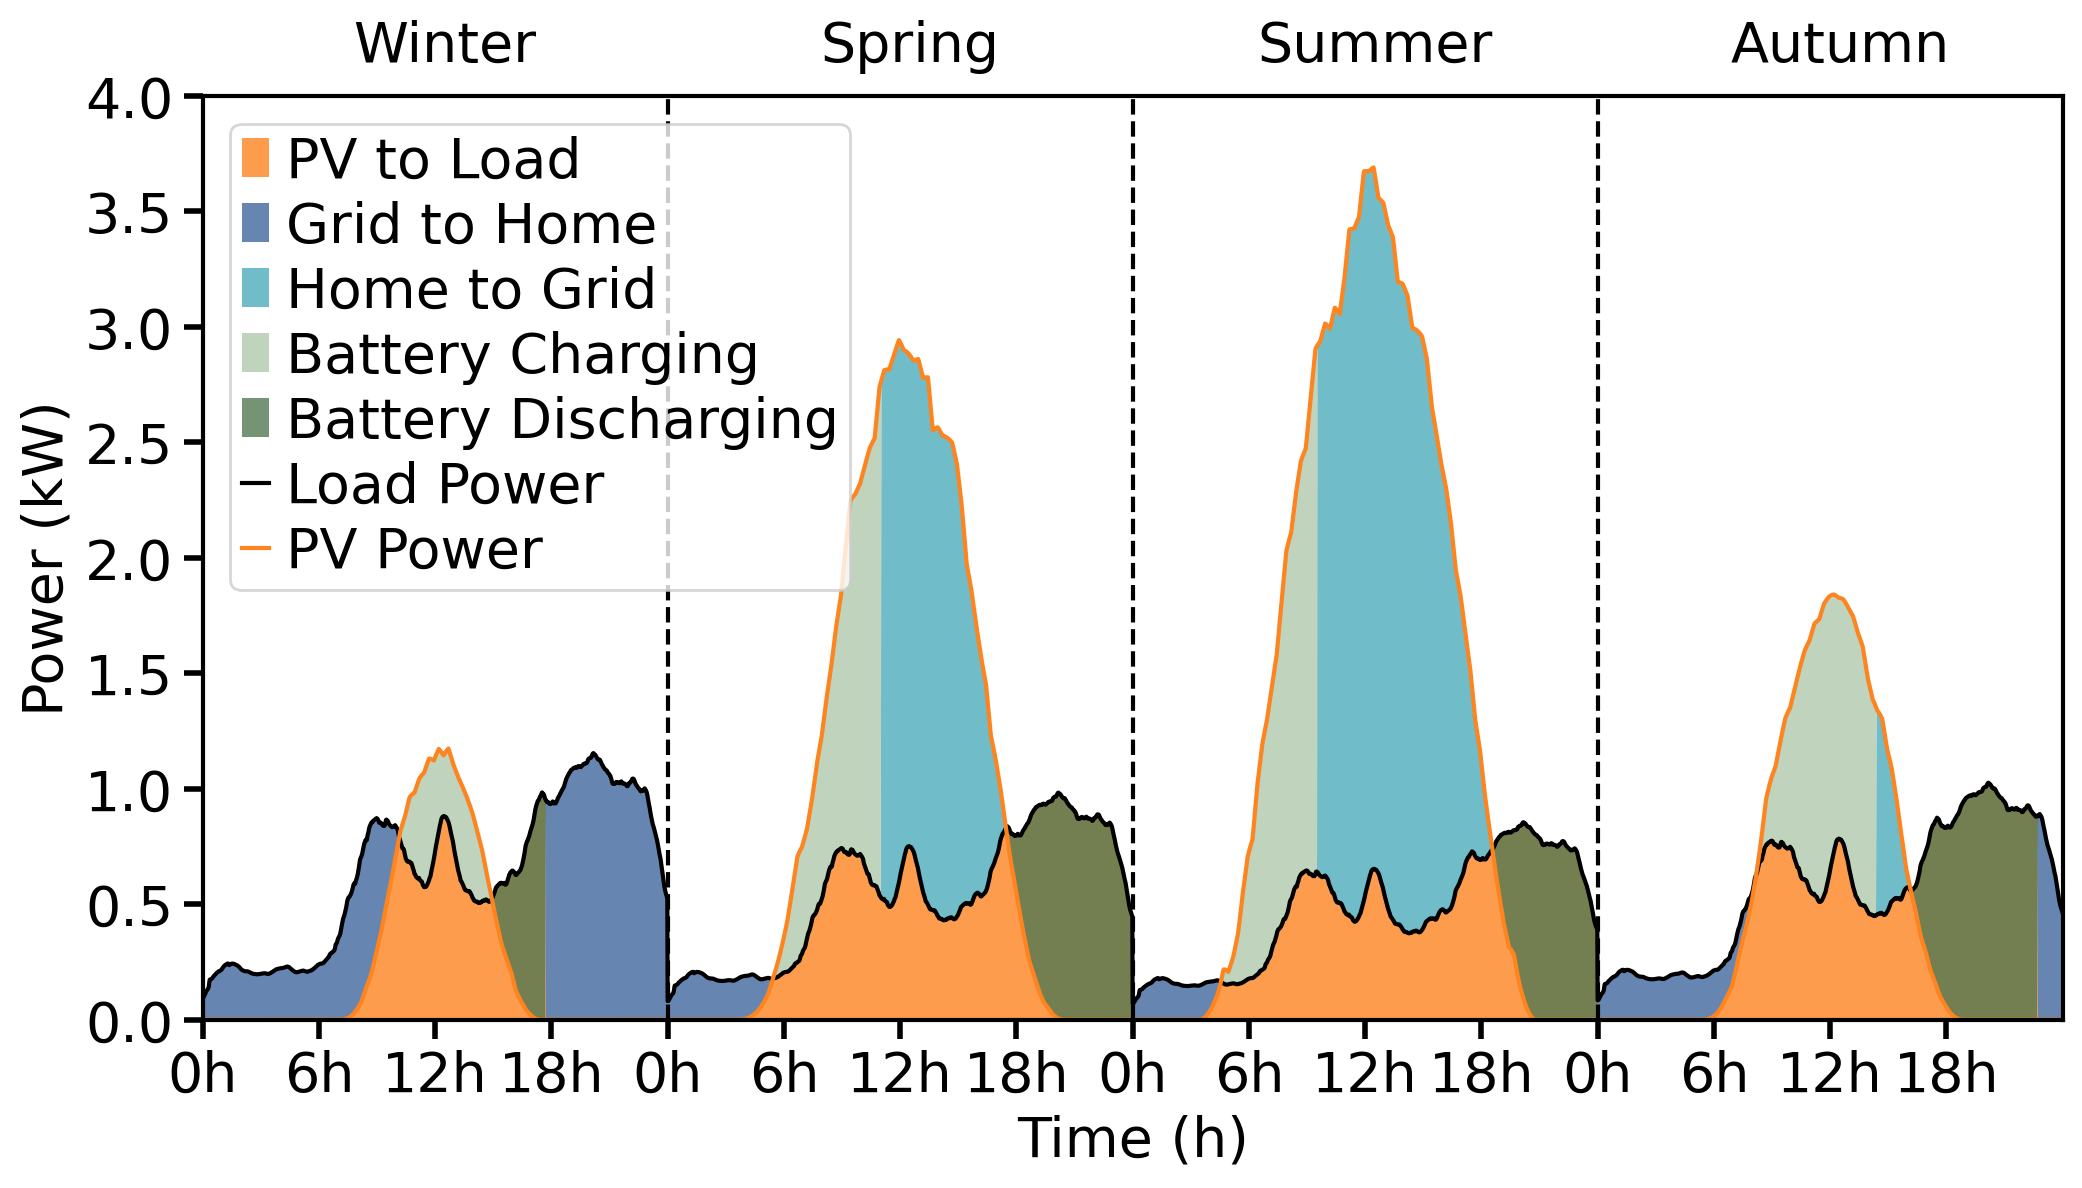

In [77]:

import matplotlib.ticker as ticker
# Now let's plot the data with improved aesthetics for IEEE submission.
plt.figure(figsize=(12, 6))

# Increase the overall font sizes for readability
plt.rcParams.update({'font.size': 20})  # Adjust as needed for IEEE guidelines

# Plot your data here as you have in your original code...

plt.stackplot(results.index, 
            (results['P_load'] - results['P_G2H'])/1000,
            results['P_G2H']/1000, 
            abs(results['P_H2G'])/1000, 
            results['Bat_charge']/1000, 
            results['Bat_discharge']/1000, 
            labels=['PV to Load','Grid to Home', 'Home to Grid', 'Battery Charging', 'Battery Discharging'], 
            colors=colors.values(),
            alpha=0.8)

plt.plot(results.index, 
        results['P_load']/1000, label='Load Power', 
        color='black')
plt.plot(results.index, 
        results['P_PV']/1000, 
        label='PV Power', color='#FD841F')

# Customizations for better readability

# Set spines to cross at (0, 0)
ax = plt.gca()  # Get the current Axes instance
# Move left and bottom spines to 0,0
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
season_centers = [750, 750+1440, (1440*2)+750, (1440*3)+750,]  # Assuming each section is 6 'ticks' wide

# Sample season names
season_names = ['Winter', 'Spring', 'Summer', 'Autumn']
# Add text annotations for each season
for x, season in zip(season_centers, season_names):
    plt.text(x, 4.15, season, horizontalalignment='center', fontsize=20)  # Adjust `max_power + 200` as needed

season_starts = [0, 1440, 2880, 4320, 5760]
season_starts = [1440, 2880, 4320]
season_midpoints = [720, 2160, 3600, 5040]
season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
# Set the limits for a cleaner look (optional)
# Set the x-ticks to be every 3 hours
tick_locations = np.arange(0, 5759 + 1, 360)
# Generate tick labels, resetting to "0h" after every 24 hours (1440 minutes)
tick_labels = [f"{(minutes // 60) % 24}h" for minutes in tick_locations]

# Update the plt.xticks call to use hour_ticks
plt.xticks(tick_locations, tick_labels)
# plt.xticks(season_starts + season_midpoints, [''] * len(season_starts) + season_labels)
plt.xlim(0, 5760)
plt.ylim([0, 4])  # for example, to set the y-limit to 20% above max PV power
for tick in season_starts:
    plt.axvline(x=tick, color='k', linestyle='--')  # k is color black, you can choose any color

# Set the thickness of the plot border lines
for _, spine in ax.spines.items():
    spine.set_linewidth(1.5)

# Increase the line width of the tick marks for visibility
ax.tick_params(which='both', width=2)  # Applies to both major and minor ticks
ax.tick_params(which='major', length=7)  # Only major ticks
ax.tick_params(which='minor', length=4, color='gray')  # Only minor ticks

# If your plot uses a grid, you can customize it too for better visibility
# ax.grid(which='both', linestyle='--', linewidth=0.5)

# Add labels and title with a larger font size
plt.xlabel('Time (h)', fontsize=20)
plt.ylabel('Power (kW)', fontsize=20)

# Make sure the legend is readable
plt.legend(fontsize='20', frameon=True, handlelength=0.5, labelspacing=0.2, handletextpad=0.3, borderpad=0.2, loc='upper left')  # Adjust the location and size as needed

# After plotting, save the figure with a higher resolution suitable for publication
# plt.savefig('/mnt/data/IEEE_figure.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

/opt/homebrew/lib/python3.11/site-packages/pvlib/pvsystem.py:2463: pvlibDeprecationWarning: 
The pvlib.pvsystem.singlediode parameter ivcurve_pnts was deprecated in pvlib 0.10.0 and will be removed in 0.11.0. Use pvlib.pvsystem.v_from_i and pvlib.pvsystem.i_from_v instead.
  warn_deprecated('0.10.0', name='pvlib.pvsystem.singlediode',


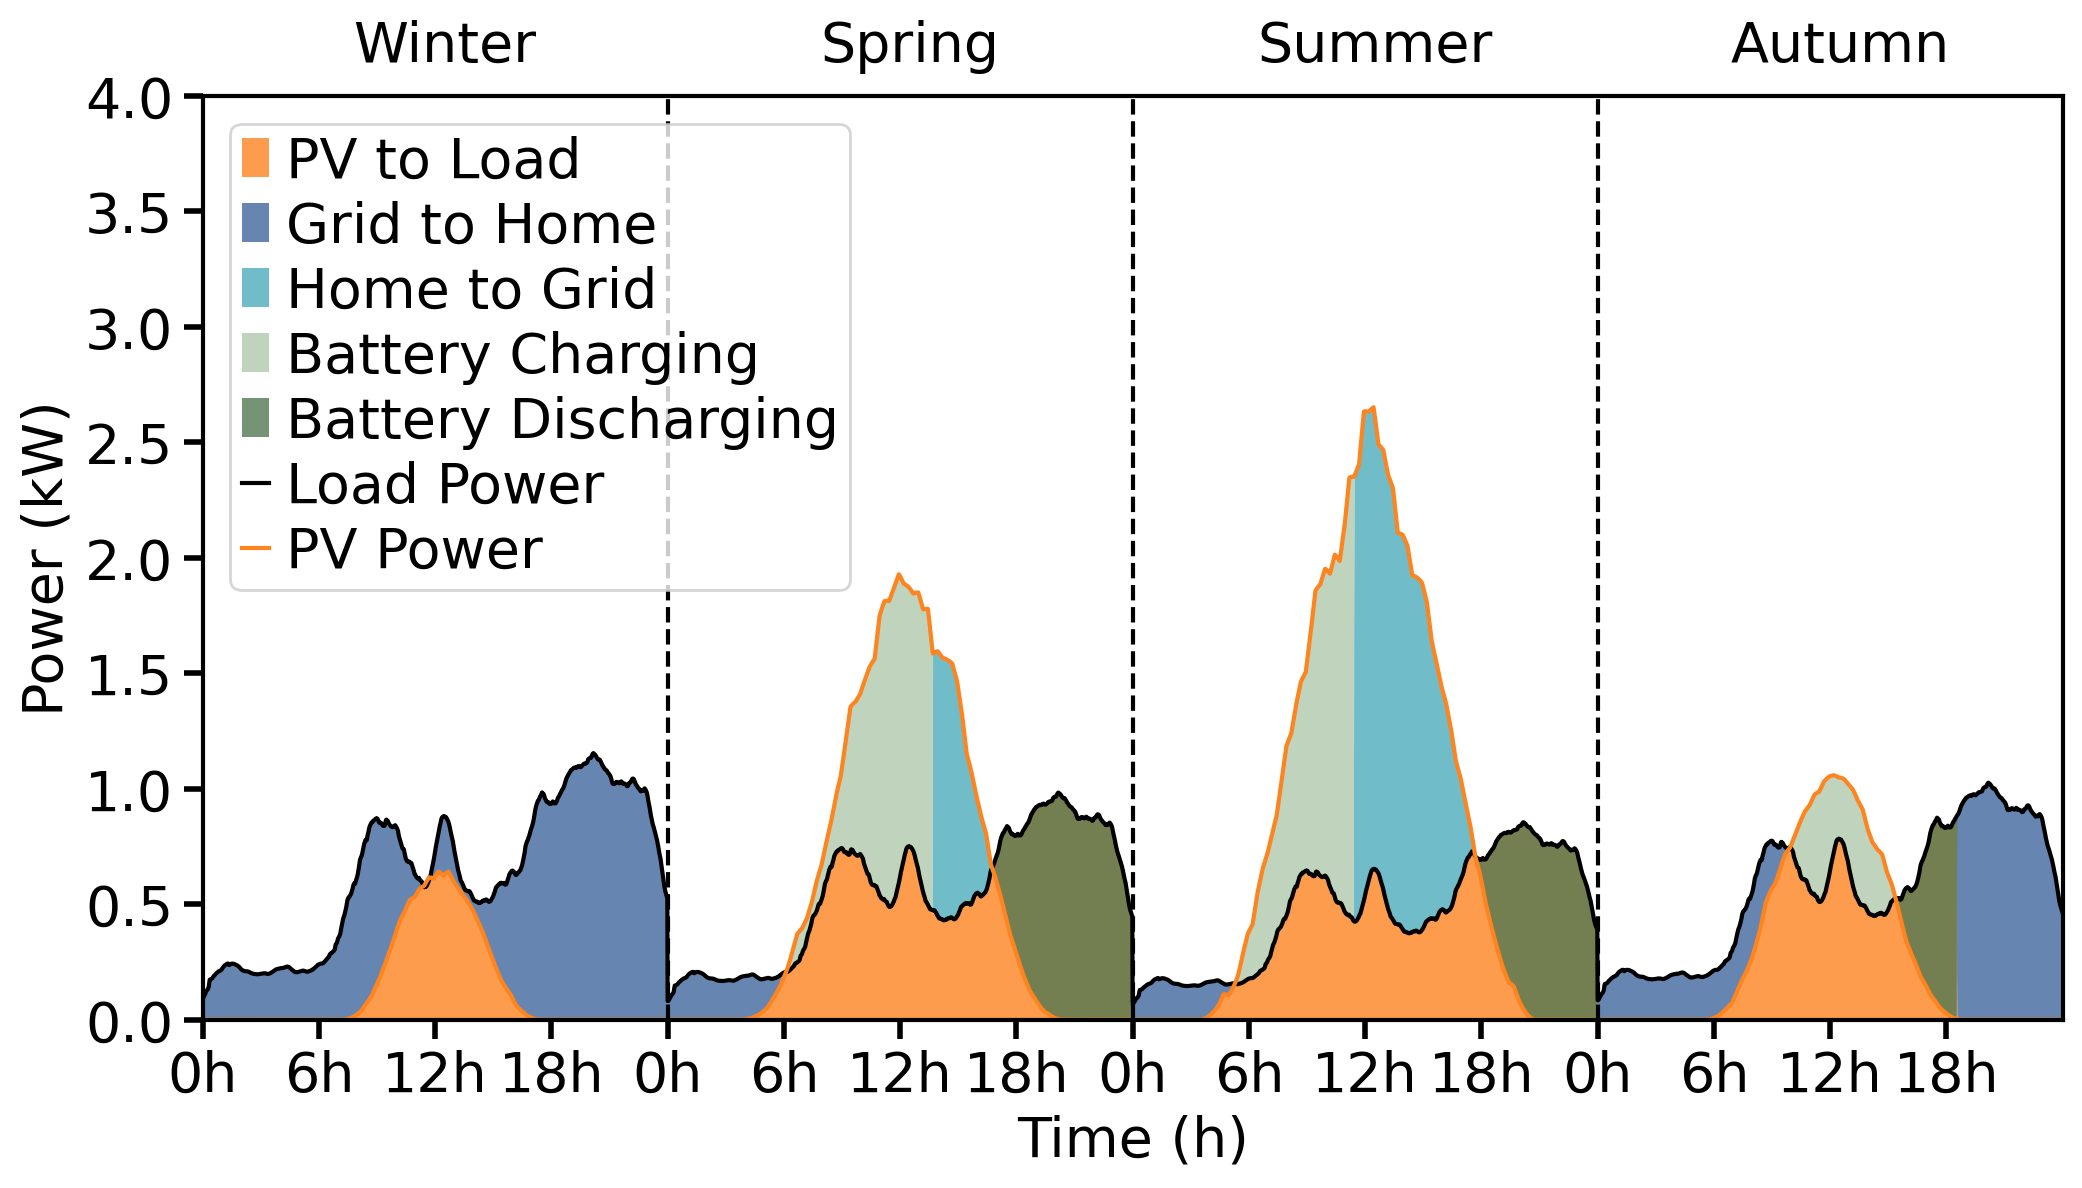

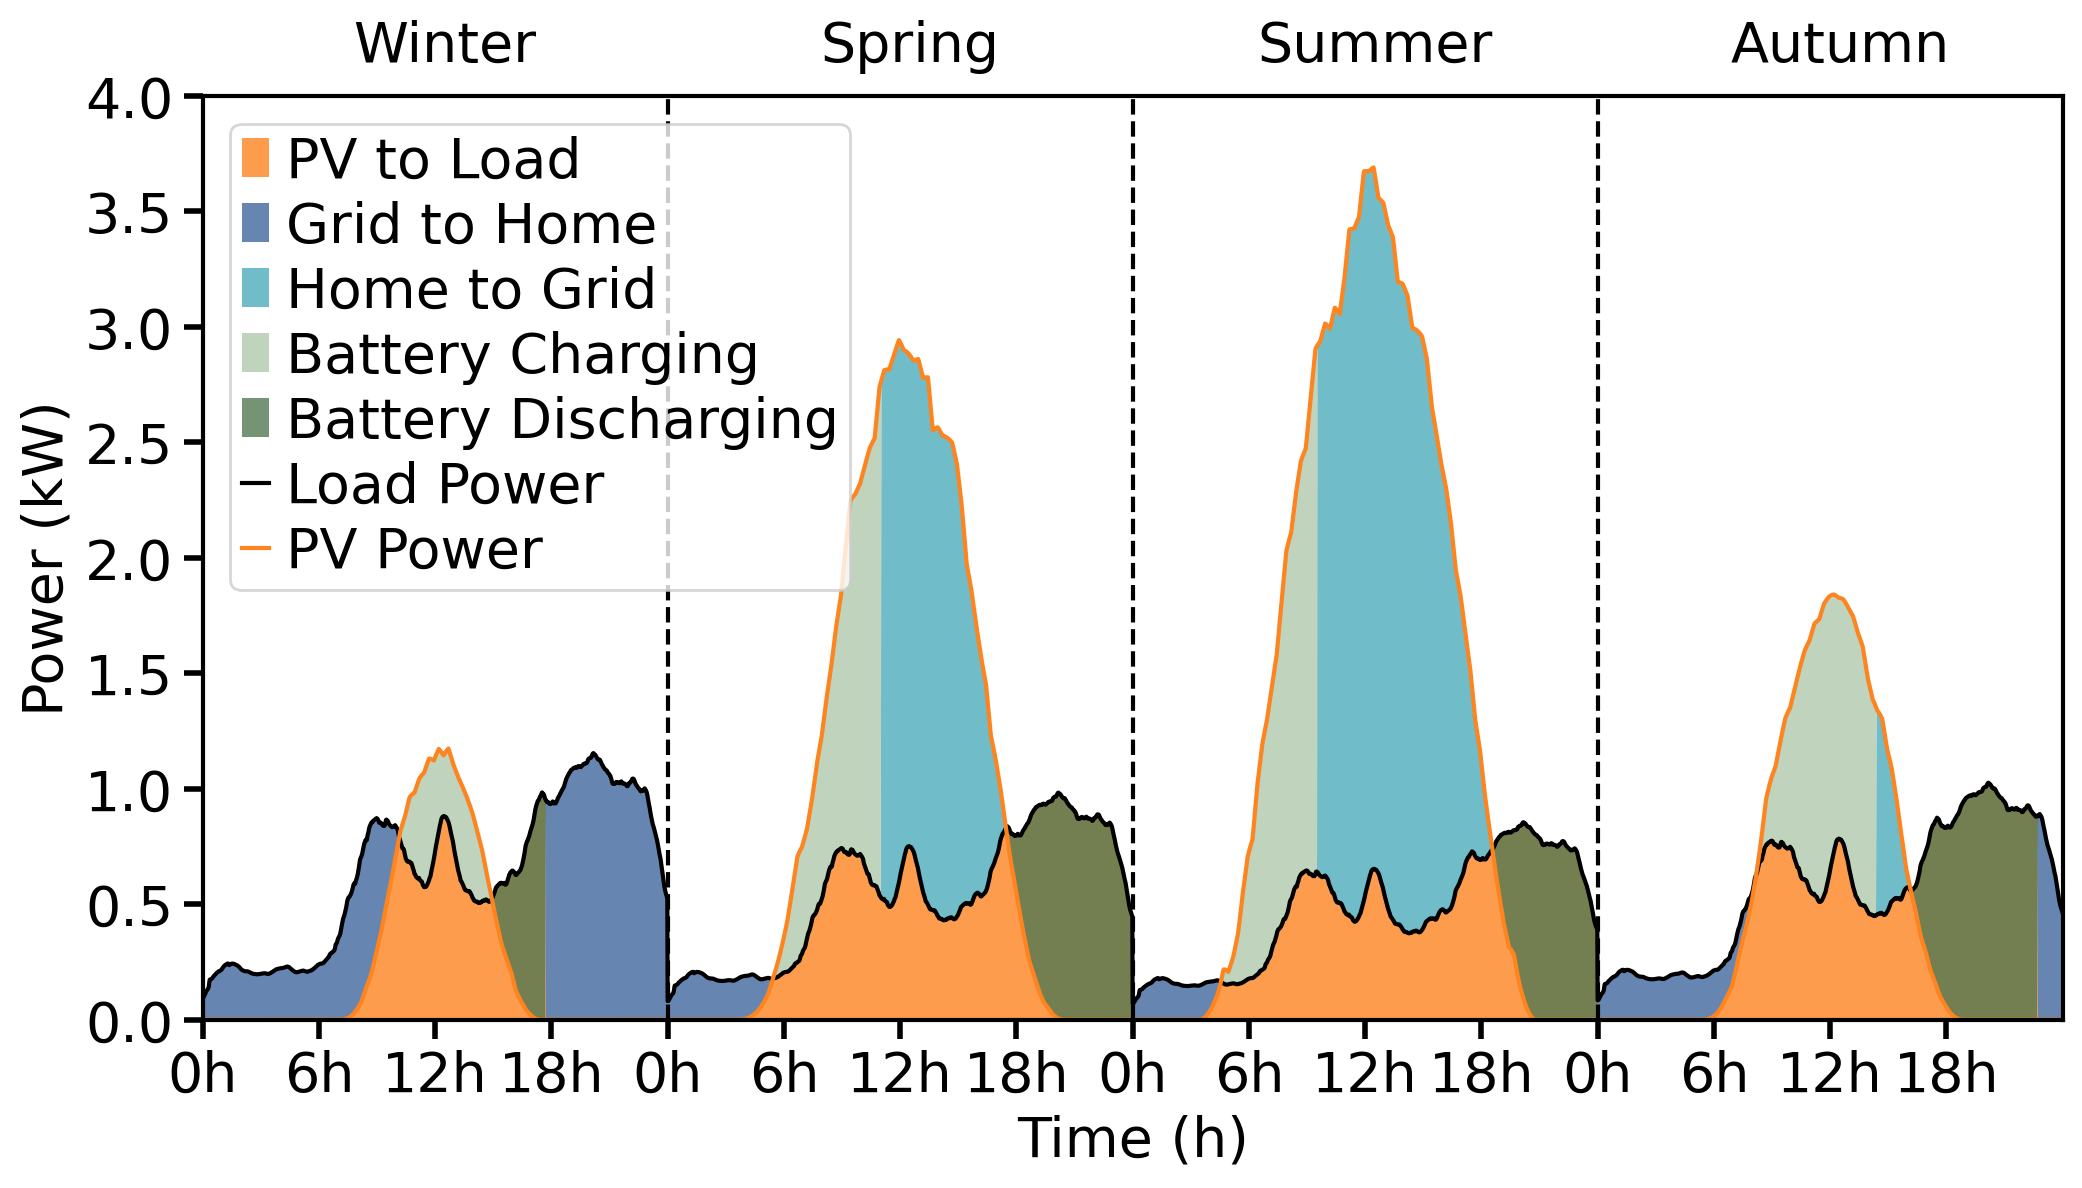

In [114]:
from pvlib import pvsystem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from parameters_pv import parameters, LLE_parameters

# Constants
C_bat = 5000  # Battery capacity in kWh, for example
n_c = 0.95  # Charging efficiency
n_d = 0.95  # Discharging efficiency
P_max_c = 2500  # Charging power max
P_max_d = 2500  # Discharging power max
delta_t = 60  # Time step in hours
SoC_max = 100  # 100%
SoC_min = 0  # 0%

irradiance = pd.read_csv('data/irradiance_seasons.csv')
temperature = pd.read_csv('data/temperature_seasons.csv')
P_load = pd.read_csv('data/load_seasons.csv') * 1000

# Combining seasonal loads
seasonal_loads = [P_load['winter'], P_load['spring'], P_load['summer'], P_load['autumn']]
P_load = pd.concat(seasonal_loads).reset_index(drop=True)

# Initialize variables
SoC = pd.Series(np.zeros(len(P_load)))  # State of Charge
P_bat = pd.Series(np.zeros(len(P_load)))  # Battery power

# color scheme
colors = {
    'P_PV': '#FD841F',    # Orange for solar PV generation
    'P_G2H': '#40679E',   # Green for generation from Grid to Hydrogen
    'P_H2G': '#4CACBC',   # Cyan for Hydrogen to Grid
    'Bat_charging': '#AFC8AD' ,   # Yellow for battery storage
    'Bat_discharging': '#527853' ,   # Yellow for battery storage
}

def PV_power_generation(irradiance, temperature, parameters, LLE_parameters):
    # Preallocate the output array
    IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
        effective_irradiance=irradiance,
        temp_cell=temperature,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
        EgRef=1.121,
        dEgdT=-0.0002677
    )
    
    curve_info = pvsystem.singlediode(
        photocurrent=IL,
        saturation_current=I0,
        resistance_series=Rs,
        resistance_shunt=Rsh,
        nNsVth=nNsVth,
        ivcurve_pnts=100,
        method='lambertw'
    )
    
    # Calculate the module power
    P_mp = curve_info['i_mp'] * curve_info['v_mp']
    
    # Calculate P_SI
    PV_data = pd.DataFrame()
    PV_data['P_Si'] = P_mp * parameters['series_cell'] * parameters['parallel_cell']

    # Adding irradiance and temperature as columns
    PV_data['irradiance'], PV_data['temperature'] = irradiance, temperature

    # Calculating delta, phi, beta values for P_LLE
    PV_data['phi'] = ((-1/100) * irradiance) + LLE_parameters['PCE_ref']
    PV_data['beta'] = 1
    PV_data['delta'] = (PV_data['phi'] * PV_data['beta'])/ LLE_parameters['PCE_min']
    PV_data['P_LLE'] = PV_data['P_Si'] * PV_data['delta']

    return PV_data

def calculate_self_consumption(P_PV):
    for t in range(1, len(P_load)):
        P_available = ((SoC_min - SoC.iloc[t-1]/100)) * (C_bat * delta_t) * n_d# Power available
        P_required = ((((SoC_max - SoC.iloc[t-1])/100) * (C_bat * delta_t)) / (n_c))  # Power required
        
        if t == 1440 or t == 2880 or t == 4320 or t == 0: 
            SoC[t-1] = 0 
        
        if P_load.iloc[t] > P_PV.iloc[t]:
            P_bat[t] = max(P_PV.iloc[t] - P_load.iloc[t], P_available, -P_max_d)
        # elif P_load.iloc[t] < P_PV.iloc[t]:
        else:
            P_bat[t] = min(P_PV.iloc[t] - P_load.iloc[t], P_required, P_max_c)
            # P_bat[t] = 0
        
        Z_bat = 1 if P_bat.iloc[t] > 0 else 0
        if Z_bat == 1 :
            SoC[t] = (SoC.iloc[t-1] + (n_c * ((P_bat.iloc[t] / delta_t) / C_bat) * 100))
        else:
            SoC[t] = SoC.iloc[t-1] + (((P_bat.iloc[t] / delta_t * n_d ) / C_bat )* 100) 

    # Calculate P_h^t , P_H2G, P_G2H
    P_h = P_load - P_PV + P_bat  
    # Divide P_h in P_H2G and P_G2H
    P_H2G = pd.Series(np.zeros(len(P_h)))  # Battery power
    P_G2H = pd.Series(np.zeros(len(P_h)))  # Battery power
    for i in range(len(P_h)):
        if P_h[i] > 0:
            P_G2H[i] = P_h[i] 
        else:
            P_H2G[i] = P_h[i] 
    # Divide in bat_charge and discharge for better graphing
    Bat_charge = pd.Series(np.zeros(len(P_bat)))  # Battery power
    Bat_discharge = pd.Series(np.zeros(len(P_bat)))  # Battery power
    for i in range(len(P_bat)):
        if P_bat[i] > 0:
            Bat_charge[i] = P_bat[i] 
        else:
            Bat_discharge[i] = P_bat[i] 
    return SoC, P_bat, P_available, P_required, P_h, P_G2H, P_H2G, Bat_charge, Bat_discharge

def stack_plot(P_load, P_G2H, P_H2G, Bat_charge, Bat_discharge, P_PV, name):        
    # Plot figure
    plt.figure(figsize=(12, 6))
    # Increase the overall font sizes for readability
    plt.rcParams.update({'font.size': 20})  # Adjust as needed for IEEE guidelines
    plt.stackplot(P_load.index, 
                (P_load - P_G2H)/1000,
                P_G2H/1000, 
                abs(P_H2G)/1000, 
                Bat_charge/1000, 
                Bat_discharge/1000, 
                labels=['PV to Load','Grid to Home', 'Home to Grid', 'Battery Charging', 'Battery Discharging'], 
                colors=colors.values(),
                alpha=0.8)

    plt.plot(P_load.index, 
            P_load/1000, label='Load Power', 
            color='black')
    plt.plot(P_PV.index, 
            P_PV/1000, 
            label='PV Power', color='#FD841F')

    ax = plt.gca()  # Get the current Axes instance
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    season_centers = [750, 750+1440, (1440*2)+750, (1440*3)+750,]  # Assuming each section is 6 'ticks' wide

    # Sample season names
    season_names = ['Winter', 'Spring', 'Summer', 'Autumn']
    # Add text annotations for each season
    for x, season in zip(season_centers, season_names):
        plt.text(x, 4.15, season, horizontalalignment='center', fontsize=20)  # Adjust `max_power + 200` as needed

    season_starts = [0, 1440, 2880, 4320, 5760]
    season_starts = [1440, 2880, 4320]
    season_midpoints = [720, 2160, 3600, 5040]
    season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
    # Set the limits for a cleaner look (optional)
    tick_locations = np.arange(0, 5759 + 1, 360)
    # Generate tick labels, resetting to "0h" after every 24 hours (1440 minutes)
    tick_labels = [f"{(minutes // 60) % 24}h" for minutes in tick_locations]

    # Update the plt.xticks call to use hour_ticks
    plt.xticks(tick_locations, tick_labels)
    plt.xlim(0, 5760)
    plt.ylim([0, 4])  # for example, to set the y-limit to 20% above max PV power
    for tick in season_starts:
        plt.axvline(x=tick, color='k', linestyle='--')  # k is color black, you can choose any color

    # Set the thickness of the plot border lines
    for _, spine in ax.spines.items():
        spine.set_linewidth(1.5)

    # Increase the line width of the tick marks for visibility
    ax.tick_params(which='both', width=2)  # Applies to both major and minor ticks
    ax.tick_params(which='major', length=7)  # Only major ticks
    ax.tick_params(which='minor', length=4, color='gray')  # Only minor ticks

    # Add labels and title with a larger font size
    plt.xlabel('Time (h)', fontsize=20)
    plt.ylabel('Power (kW)', fontsize=20)
    # Make sure the legend is readable
    plt.legend(fontsize='20', frameon=True, handlelength=0.5, labelspacing=0.2, handletextpad=0.3, borderpad=0.2, loc='upper left')  # Adjust the location and size as needed
    plt.show()

# Calculate power output for Si and LLE
PV_data = PV_power_generation(irradiance['GHI'], temperature['t2m'], parameters, LLE_parameters)

# Calculate self consumption for each technology
SoC_Si, P_bat_Si, P_available_Si, P_required_Si, P_h_Si, P_G2H_Si, P_H2G_Si, Bat_charge_Si, Bat_discharge_Si = calculate_self_consumption(PV_data['P_Si'])
SoC_LLE, P_bat_LLE, P_available_LLE, P_required_LLE, P_h_LLE, P_G2H_LLE, P_H2G_LLE, Bat_charge_LLE, Bat_discharge_LLE = calculate_self_consumption(PV_data['P_LLE'])

# Plot both technologies
stack_plot(P_load, P_G2H_Si, P_H2G_Si, Bat_charge_Si, Bat_discharge_Si, PV_data['P_Si'], 'Silicon')
stack_plot(P_load, P_G2H_LLE, P_H2G_LLE, Bat_charge_LLE, Bat_discharge_LLE, PV_data['P_LLE'], 'LLE')

9.2595135025037


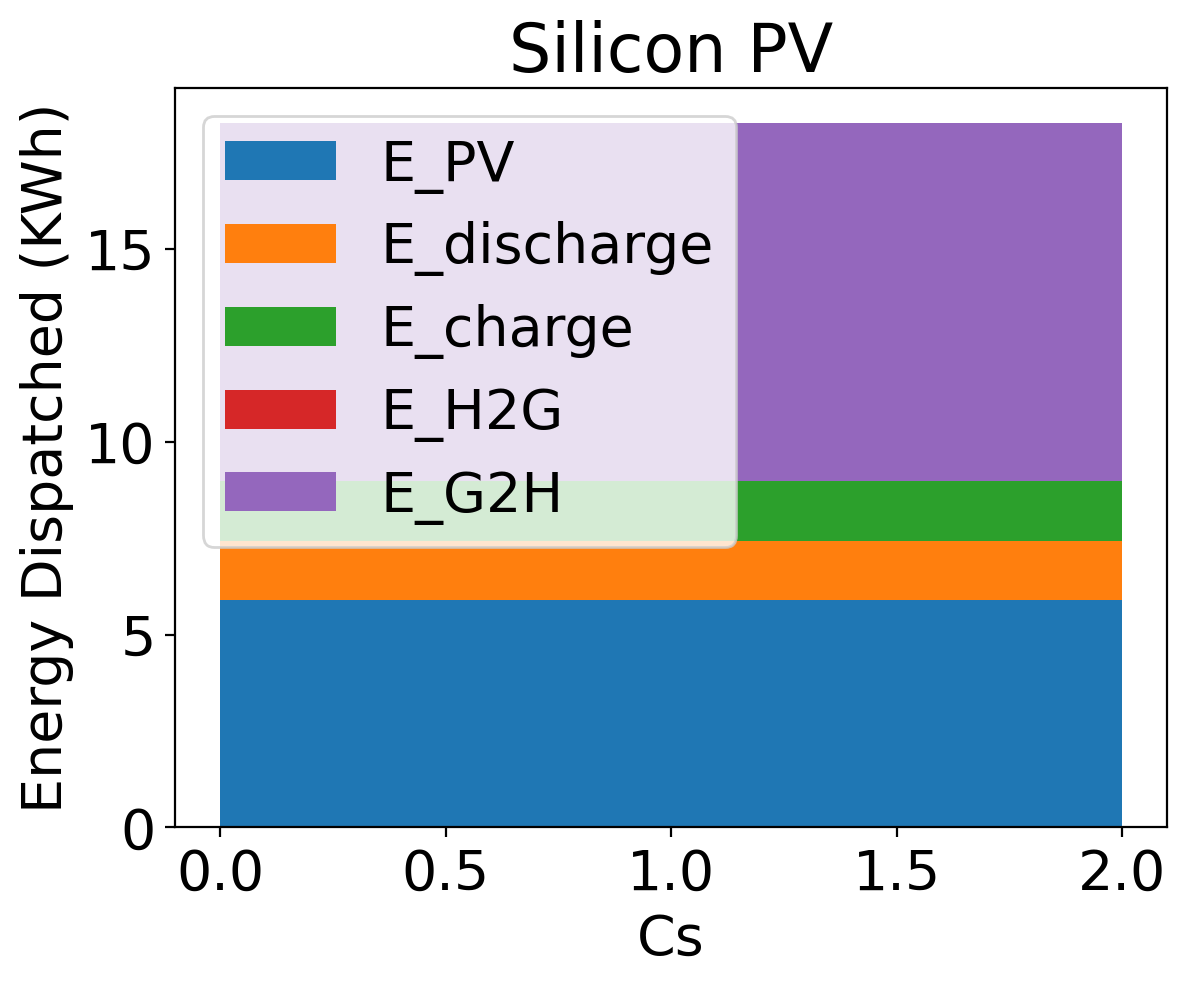

In [113]:
# Example data
categories = np.array([0.0, 0.5, 1.0, 1.5, 2.0])  # Replace with your actual x-axis categories
# ... Add data for other energy sources

# Stack the data
plt.stackplot(categories, E_PV, abs(E_discharge), E_charge, E_H2G, E_G2H, labels=['E_PV', 'E_discharge', 'E_charge', 'E_H2G', 'E_G2H'])

# Add titles and labels
plt.title('Silicon PV')
plt.xlabel('')
plt.ylabel('Energy Dispatched (KWh)')

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.show()
